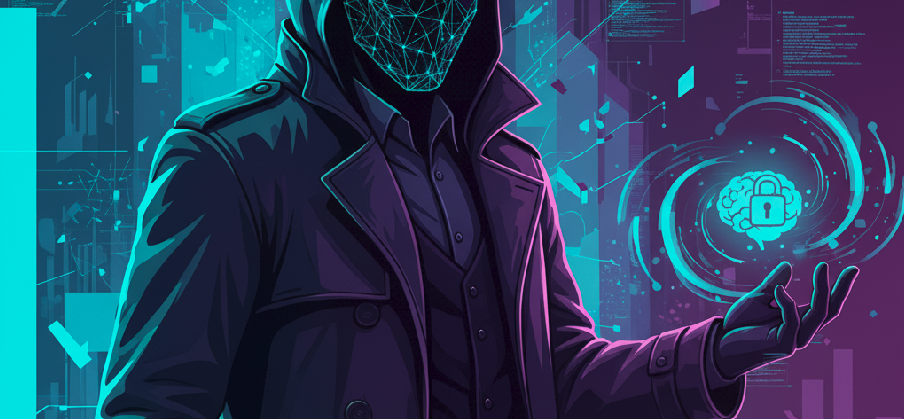

# Mission Compressible

A Hírszerzésnek dolgozol, és épp most kaparintottál meg egy kulcsfontosságú nyelvi modellt, amivel a lehallgatott üzeneteket tudnád klasszifikálni. A titkosított meghajtódon már csak 200 MB hely maradt, a modell pedig nem fér rá jelenlegi formájában. Tömörítened kell modellt, és bíznod abban, hogy nem csökken drasztikusan a teljesítménye!

Feladatod:


*   kvantáld a modellt FP32-ről INT8-ba **torch.quantization.quantize_dynamic** használatával
*   mérd meg, hogy mennyit romlik a háló pontossága a teszthalmazon
*   és, hogy mekkora lett a kvantált modell fájl mérete. Vajon ráfér a pendrivera?

A válasznak add meg egészre kerekítve, mértékegység nélkül, vesszővel elválasztva python listaként:

*  az eredeti pontosságot (pl. 89 %)
*  az új pontosságot (pl. 86 %)
*  és a kvantált fájl méretét (pl 100 MB)

pl "[89, 86, 100]" formában!


GPU nem kell a feladat megoldásához!

In [ ]:
!pip install transformers datasets torch --quiet

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import os
import tempfile
import time
import random
import numpy as np

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Minta adat és a megkaparintott modell

In [ ]:
# minta adat betöltése
dataset = load_dataset("ag_news", split="test").select(range(100))

texts = [x["text"] for x in dataset]
labels = torch.tensor(dataset["label"])
label_names = ["World", "Sports", "Business", "Sci/Tech"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# a megkaparintott modell:
model_name = "textattack/bert-base-uncased-ag-news"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).eval()

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Inference (FP32) - az eredeti modell
with torch.no_grad():
    preds_fp32 = model(**inputs).logits.argmax(1)
accuracy_fp32 = (preds_fp32 == labels).float().mean().item()


In [ ]:
# Modell file mérete
with tempfile.NamedTemporaryFile(delete=False) as f1:
    torch.save(model.state_dict(), f1.name)
    size_fp32 = os.path.getsize(f1.name)/ (1024*1024)

print(f"Original model file size:{size_fp32} MB")

Original model file size:417.7296533584595 MB


##A feladat

In [ ]:
# Dynamic Quantization - csak a Lineáris rétegek kvantálása
quantized_model =  torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

/tmp/ipython-input-3734584679.py:2: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model =  torch.quantization.quantize_dynamic(


In [ ]:
# Inference (INT8) - a kvantált modell
with torch.no_grad():
    preds_int8 = quantized_model(**inputs).logits.argmax(1)
accuracy_int8 = (preds_int8 == labels).float().mean().item()

In [ ]:
# Modell file mérete
with tempfile.NamedTemporaryFile(delete=False) as f1:
    torch.save(quantized_model.state_dict(), f1.name)
    size_int8 = os.path.getsize(f1.name)/ (1024*1024)

print(f"Quantized model file size:{size_int8} MB")

# redukció százalékosan
size_reduction = 100 * (1 - size_int8 / size_fp32)

Quantized model file size:173.08900547027588 MB


In [ ]:
# a válasz
ans1 = round(accuracy_fp32 * 100)
ans2 = round(accuracy_int8 * 100)
ans3 = round(size_int8)

print([ans1,ans2,ans3])

[97, 96, 173]


In [ ]:
accuracy_fp32

0.9599999785423279